In [1]:
import pandas as pd
import requests
import zipfile
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20  

# Download the zip file from Google Drive
url = 'https://drive.google.com/uc?export=download&id=1LiOAeu4r9EPflCuCTJUosCUO4gqGdBsI'

response = requests.get(url)

# Extract the zip file content directly from the response
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall()

# Load the data from the Excel files in the extracted directory
data_frames = {}
for root, dirs, files in os.walk('.'):
    for file_name in files:
        if file_name.endswith('.xlsx'):
            file_path = os.path.join(root, file_name)
            data_frames[file_name] = pd.read_excel(file_path)

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler

scaler = MinMaxScaler()

# Columns to normalize
columns_to_normalize = ['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4']

# Normalize the specified columns in each data frame
for key in data_frames.keys():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        data_frames[key][columns_to_normalize] = scaler.fit_transform(data_frames[key][columns_to_normalize])


In [3]:
# Group by 'Temporal Frequency' and 'Noise Size', then calculate the mean for each illusion
average_illusions_data = []
for key in data_frames.keys():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        grouped_data = data_frames[key].groupby(['Temporal Frequency', 'Noise Size']).mean().reset_index()
        average_illusions_data.append(grouped_data)

# Combine all the grouped data frames into one
data_combined = pd.concat(average_illusions_data, ignore_index=True)

In [4]:
# Group by 'Temporal Frequency' and 'Noise Size', and calculate mean and standard deviation
grouped = data_combined.groupby(['Temporal Frequency', 'Noise Size'])
mean_df = grouped.mean().reset_index()
std_dev_df = grouped.std().reset_index()

# Rename columns to indicate that these are means and standard deviations
mean_columns = {
    'illusion 1': 'illusion 1 mean',
    'illusion 2': 'illusion 2 mean',
    'illusion 3': 'illusion 3 mean',
    'illusion 4': 'illusion 4 mean'
}
std_dev_columns = {
    'illusion 1': 'illusion 1 std dev',
    'illusion 2': 'illusion 2 std dev',
    'illusion 3': 'illusion 3 std dev',
    'illusion 4': 'illusion 4 std dev'
}

mean_df.rename(columns=mean_columns, inplace=True)
std_dev_df.rename(columns=std_dev_columns, inplace=True)

# Optionally, we can merge the mean and standard deviation dataframes for a combined view
result_df = pd.merge(mean_df, std_dev_df, on=['Temporal Frequency', 'Noise Size'])

In [5]:
# Prepare the grid for interpolation
temp_freqs = np.linspace(result_df['Temporal Frequency'].min(), result_df['Temporal Frequency'].max(), 100)
noise_sizes = np.linspace(result_df['Noise Size'].min(), result_df['Noise Size'].max(), 100)
temp_freq_grid, noise_size_grid = np.meshgrid(temp_freqs, noise_sizes)

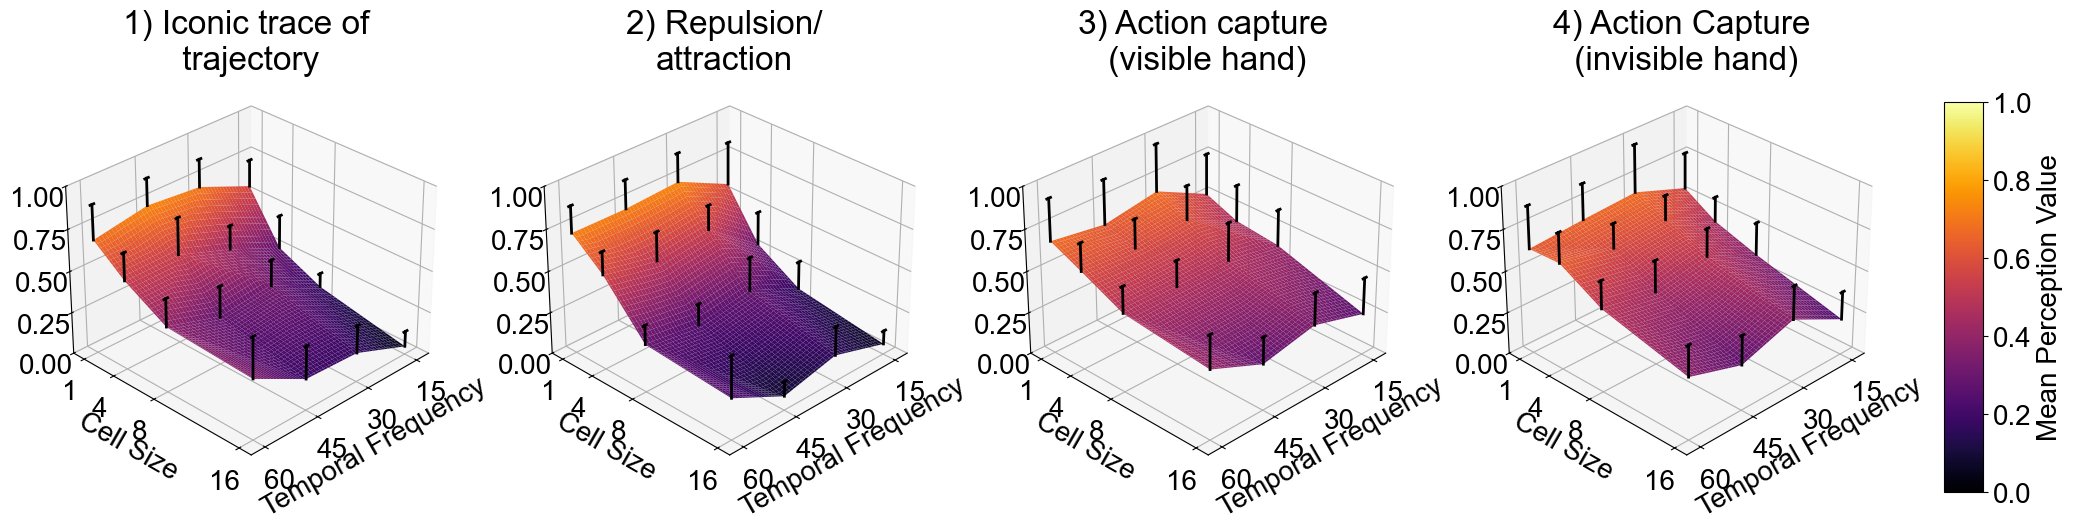

In [6]:
def plot_means_and_std_devs_of_illusions(df):
    # Enlarging the figure might help in fitting all components
    fig, axs = plt.subplots(1, 4, subplot_kw={'projection': '3d'}, figsize=(26, 8))  # Adjusted figure size
    fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.4)  # Adjust these as needed

    titles = ['1) Iconic trace of\n trajectory', '2) Repulsion/\nattraction', '3) Action capture\n (visible hand)', '4) Action Capture\n (invisible hand)']
    temp_freq_grid, noise_size_grid = np.meshgrid(np.linspace(df['Temporal Frequency'].min(), df['Temporal Frequency'].max(), 100),
                                                  np.linspace(df['Noise Size'].min(), df['Noise Size'].max(), 100))

    # Updated to include all specified temporal frequencies
    temporal_frequencies = [15, 30, 45, 60]
    df_filtered = df[df['Temporal Frequency'].isin(temporal_frequencies)]
    noise_sizes = [1, 4, 8, 16]

    for i in range(4):
        mean_col = f'illusion {i+1} mean'
        mean_interpolated = griddata(
            (df['Temporal Frequency'], df['Noise Size']),
            df[mean_col],
            (temp_freq_grid, noise_size_grid),
            method='linear'
        )
        surf_mean = axs[i].plot_surface(temp_freq_grid, noise_size_grid, mean_interpolated, cmap='inferno', vmin=0, vmax=1)
        axs[i].view_init(elev=30, azim=45)
        axs[i].set_title(titles[i])
        axs[i].set_xlabel('Temporal Frequency')
        axs[i].set_ylabel('Cell Size')
        axs[i].set_xticks(temporal_frequencies)
        axs[i].set_yticks(noise_sizes)
        axs[i].set_zlim(0, 1)

        for freq in temporal_frequencies:
            for j, noise in enumerate(noise_sizes):
                point_mean = griddata(
                    (df['Temporal Frequency'], df['Noise Size']),
                    df[mean_col],
                    (np.array([freq]), np.array([noise])),
                    method='linear'
                )
                point_mean = point_mean[0] if point_mean.shape else point_mean
                std_dev = df_filtered[(df_filtered['Temporal Frequency'] == freq) & (df_filtered['Noise Size'] == noise)][f'illusion {i+1} std dev'].values
                if std_dev.size > 0:
                    axs[i].plot([freq, freq], [noise, noise], [point_mean, point_mean + std_dev[0]], 'k-', linewidth=2, zorder=10)
                    axs[i].plot([freq - 0.5, freq + 0.5], [noise, noise], [point_mean + std_dev[0], point_mean + std_dev[0]], 'k-', linewidth=2, zorder=10)

    cbar = fig.colorbar(surf_mean, ax=axs, shrink=0.6, aspect=10, pad=0.02)
    cbar.set_label('Mean Perception Value')
    cbar.ax.set_position([0.78, 0.15, 0.015, 1.0])  # Adjusted to prevent overlap
    plt.savefig('./illusions_mean.svg', format='svg', bbox_inches='tight')  # Ensure to use bbox_inches
    plt.show()

# Example usage
plot_means_and_std_devs_of_illusions(result_df)
